In [ ]:
using Revise, DrWatson
@quickactivate "haram"

In [ ]:
using main
using Plots, Random, Distributions, ProgressMeter
using Flux, DynamicPPL, Zygote

gr(fmt=:png, levels=7, lw=0.5, msw=0.5, la=0.5)
theme(:default)
cls = palette(:viridis, rev=false)
ProgressMeter.ijulia_behavior(:clear);

In [ ]:
function plot_colorbar(cls)
    scatter([0, 0], [0, 1],
        zcolor=[0, 1], clims=(0, 1), xlims=(1, 1.1), c=cls,
        label="", colorbar_title="", framestyle=:none
    )
end

function nn_plot(theta; res=25, c=:viridis)
    x_range = collect(range(-6; stop=6, length=res))
    contourf(
        x_range, x_range,
        (x, y) -> f(theta)([x, y])[1], c=c
    )
    scatter!(
        Tuple.(eachrow(xs)),
        c=map(x -> x == 1 ? :firebrick1 : :dodgerblue1, ys),
        m=map(x -> x == 1 ? :square : :circle, ys),
        group=ys,
        legend=:bottomright
    )
end

function nn_plot_mean(thetas; F=mean, c=:viridis, res=25, bar=false)
    x_range = collect(range(-6; stop=6, length=res))
    contourf(
        x_range, x_range,
        (x, y) -> F([f(theta)([x, y])[1] for theta in eachrow(thetas)]), c=c, colorbar=bar,
    )
    scatter!(
        Tuple.(eachrow(xs)),
        c=map(x -> x == 1 ? :firebrick1 : :dodgerblue1, ys),
        m=map(x -> x == 1 ? :square : :circle, ys),
        group=ys,
        legend=:bottomright
    )
end

function make_model(ξ::DynamicPPL.Model, d)
    U(x) = min(-logjoint(ξ, (; θ=x)), floatmax(Float64))
    dU(x) = Zygote.gradient(x_ -> Zygote.forwarddiff(U, x_), x)[1]
    f(x) = max(exp(-U(x)), floatmin(Float64))
    g(x) = Zygote.gradient(x_ -> Zygote.forwarddiff(f, x_), x)
    return main.Model(ξ=ξ, d=d, f=f, g=g, U=U, dU=dU)
end

In [ ]:
Random.seed!(2022)
s = 0.4
μ = [[1.0 1.0], [-1.0 -1.0], [1.0 -1.0], [-1.0 1.0],] .* 1
x1 = [sqrt(s) .* randn(10, 2) .+ μ[3]; sqrt(s) .* randn(100, 2) .+ μ[4]]
x0 = [sqrt(s) .* randn(50, 2) .+ μ[1]; sqrt(s) .* randn(60, 2) .+ μ[2]]
xs = [x0; x1]
ys = [zeros(size(x0, 1)); ones(size(x1, 1))] .|> Int;

In [ ]:
scatter(Tuple.(eachrow(xs)), group=ys, ratio=1)

In [ ]:
F = Chain(
    Dense(2, 2, leakyrelu),
    Dense(2, 2, leakyrelu),
    Dense(2, 1, sigmoid)
)

θ, f = Flux.destructure(F)
sigma = sqrt(1.0 / 0.09)

@model function bayes_nn(xs, ys, nθ, f)
    θ ~ MvNormal(zeros(nθ), sigma .* ones(nθ))
    F = f(θ)
    ps = F(xs)
    for i in eachindex(ys)
        ys[i] ~ Bernoulli(ps[i])
    end
end;

ξ = bayes_nn(xs', ys, length(θ), f)
model = make_model(ξ, length(θ));

In [ ]:
Random.seed!(2022)
s1, a1 = mcmc(
    HMC(ϵ=5e-2, L=10),
    model; n=2_000, n_burn=500,
)
x_hmc = s1[a1, :];

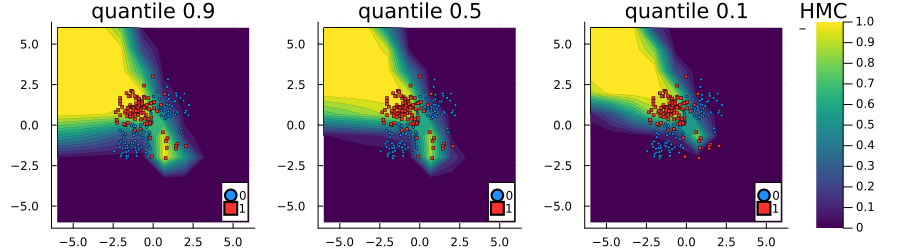

GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [37]:
plt_hmc = plot(
    nn_plot_mean(x_hmc[sample(1:end, 100), :], res=10, F=x -> quantile(x, 0.9)),
    nn_plot_mean(x_hmc[sample(1:end, 100), :], res=10, F=x -> quantile(x, 0.5)),
    nn_plot_mean(x_hmc[sample(1:end, 100), :], res=10, F=x -> quantile(x, 0.1)),
    plot_colorbar(cls),
    layout=(@layout [grid(1,3) a{0.05w}]), size=(900, 250), 
    title=["quantile " .* string.([0.9 0.5 0.1]) "HMC"], ms=1.5, lw=0.1, lc=:black
)

In [26]:
Random.seed!(2022)
s2, a2 = mcmc(
    HaRAM(ϵ=5e-2, L=7, γ=0.75),
    model; n=1_000, n_burn=200
)
x_haram = s2[a2, :];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
  HaRAM(0.05, 7, 0.75, Any[]):  0.5203996669442131


Acceptance Ratio = 0.514


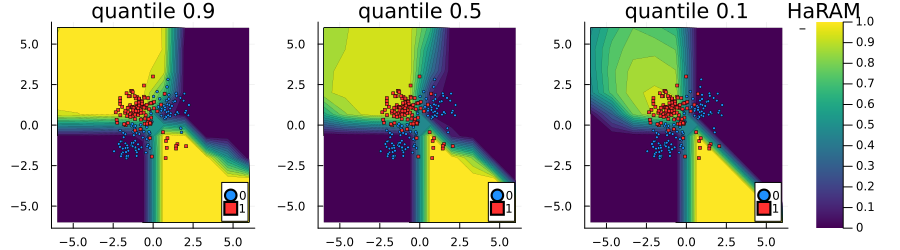

GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [36]:
plt_haram = plot(
    nn_plot_mean(x_haram[sample(1:end, 100), :], res=10, F=x -> quantile(x, 0.9)),
    nn_plot_mean(x_haram[sample(1:end, 100), :], res=10, F=x -> quantile(x, 0.5)),
    nn_plot_mean(x_haram[sample(1:end, 100), :], res=10, F=x -> quantile(x, 0.1)),
    plot_colorbar(cls),
    layout=(@layout [grid(1,3) a{0.05w}]), size=(900, 250), ms=1.5, lw=0.1, lc=:black,
    title=["quantile " .* string.([0.9 0.5 0.1]) "HaRAM"]
)

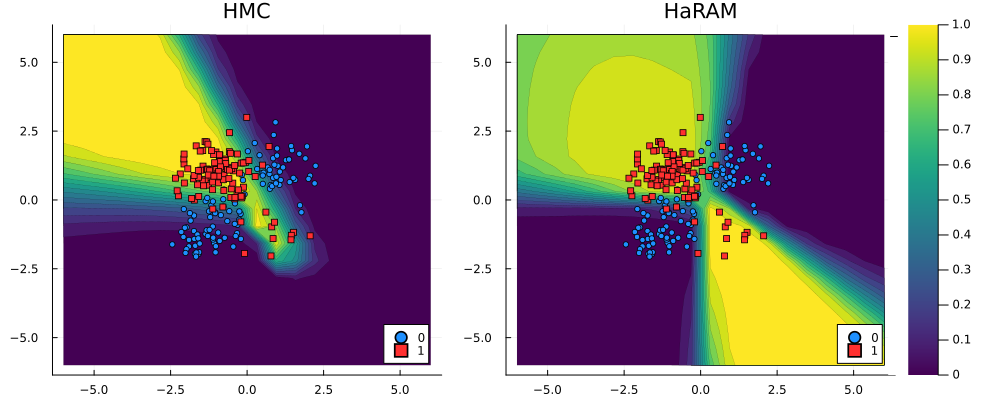

GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [28]:
st, res, N = 2, 20, 1000
cls = palette(:viridis, rev=false)

plot(
    plot(
        nn_plot_mean(x_hmc[sample(1:end, N), :], res=res, c=cls),
    colorbar=false, title="HMC",
    ),
    plot(
        nn_plot_mean(x_haram[sample(1:end, N), :], res=res, c=cls),
        colorbar=false, title="HaRAM",
    ),
    plot_colorbar(cls),
    layout=(@layout [grid(1, 2) a{0.035w}]),
    link=:all,
     ms=3.0, lw=0.1, lc=:black,
    size=(1000, 400)
)

In [29]:
savefig(plotsdir("nn/contourf.pdf")); savefig(plotsdir("nn/contourf.svg"))

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


"/storage/work/s/suv87/julia/haram/plots/nn/contourf.svg"

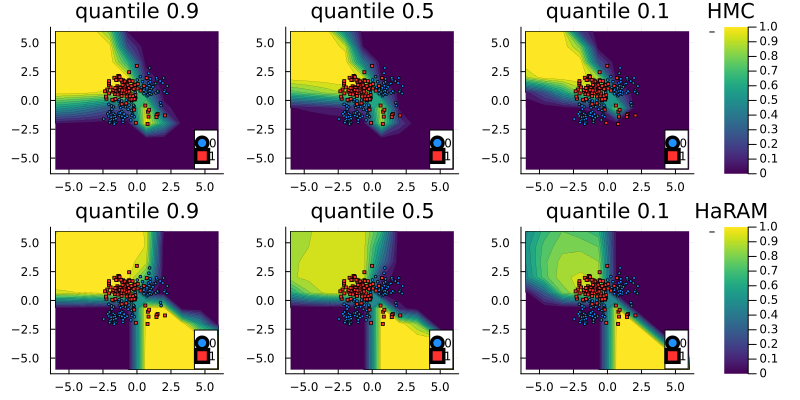

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [40]:
plot(plt_hmc, plt_haram, layout=(2,1), size=(800, 400))

In [41]:
savefig(plotsdir("nn/all.pdf")); savefig(plotsdir("nn/all.svg"))

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


"/storage/work/s/suv87/julia/haram/plots/nn/all.svg"

In [42]:
scatter(Tuple.(eachrow(xs)), group=ys, ratio=1)
savefig("/storage/home/suv87/work/slides/oct21/images/plots/nn/scatter.svg")

"/storage/home/suv87/work/slides/oct21/images/plots/nn/scatter.svg"